In [4]:
import pandas as pd
import numpy as np
import json
import pickle
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, LineString,MultiLineString,Polygon
from shapely import ops
import matplotlib.pyplot as plt
%matplotlib inline
import os
import folium
attr='(c) <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors (c) <a href="http://cartodb.com/attributions">CartoDB</a>, CartoDB <a href ="http://cartodb.com/attributions">attributions</a>'
from selenium import webdriver
import PIL
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import glob
import moviepy.editor as mpy
from flask import request

In [2]:
# Define the API endpoint
url = "https://data.traffic.hereapi.com/v7/flow"

# Define the query parameters
params = {
    "locationReferencing": "shape",
    #"in": "bbox:107.54908372065572,-6.926620456605005,107.72967148820469,-6.896286771555365",
    "in": "bbox:107.2510292754,-7.3097642655,107.9384321719,-6.8128449268",
    "apiKey": "z1hUE5rH83_F6uIgubqDkRHn6JQK8s5tUa106Nudp6c",
    "responseattributes": "sh,fc"
}


In [4]:
"https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc"

'https://traffic.api.here.com/traffic/6.3/flow.json?bbox=-6.926620456605005,107.54908372065572;-6.896286771555365,107.72967148820469&apiKey=Cdfx4rTgJqyfEJv1ydzReBDhwqpkx1PymIp4UjaYWvc&responseattributes=sh,fc'

In [9]:
from shapely.geometry import Point, LineString
import geopandas as gpd

def dataframe (filename):
    with open(filename, 'r') as f:
        data = json.load(f)

    rows = []
    for result in data['results']:
        location = result['location']
        description = location['description']
        length = location['length']
        links = location['shape']['links']
        latitudes = []
        longitudes = []
        for link in links:
            if 'points' in link:
                for point in link['points']:
                    latitudes.append(point['lat'])
                    longitudes.append(point['lng'])
        speed = result['currentFlow']['speed']
        freeflow = result['currentFlow']['freeFlow']
        jamfactor = result['currentFlow']['jamFactor']
        rows.append([description, length, latitudes, longitudes, speed, freeflow, jamfactor])

    return (pd.DataFrame(rows, columns=['Description', 'Length', 'Latitudes', 'Longitudes', 'Speed', 'FreeFlow', 'JamFactor']))


In [23]:
df = dataframe('2023-03-28 20-19-22.json')

In [24]:
df

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor
0,Jalan Taman Singosari Ujung/Jalan Melong Asih,93.0,"[-6.918920008465648, -6.919689970090985]","[107.56337997503579, 107.56304997950792]",5.277778,5.277778,0.0
1,Jalan Jenderal Ahmad Yani,164.0,"[-6.901899967342615, -6.901920000091195, -6.90...","[107.65356003306806, 107.65380998142064, 107.6...",5.833334,8.333334,1.9
2,Jalan Cisaat,48.0,"[-6.941419970244169, -6.941130040213466, -6.94...","[107.53402998670936, 107.53412998281419, 107.5...",4.444445,4.444445,0.0
3,Jalan Sunda,49.0,"[-6.915920041501522, -6.915909983217716, -6.91...","[107.61835997924209, 107.61831002309918, 107.6...",6.666667,6.944445,0.4
4,Jalan Elang Raya,18.0,"[-6.915549980476499, -6.915609994903207]","[107.57482999004424, 107.574980026111]",3.888889,2.777778,0.0
...,...,...,...,...,...,...,...
2328,Jalan M. K. Wiganda Sasmita,58.0,"[-6.8698700331151485, -6.8703000247478485]","[107.54390001296997, 107.54360002465546]",4.722222,5.833334,0.3
2329,Jalan Terusan,170.0,"[-6.870059967041016, -6.870149988681078, -6.87...","[107.54414996132255, 107.54425004124641, 107.5...",5.277778,5.555556,0.3
2330,Jalan Terusan,367.0,"[-6.872619967907667, -6.8724300339818, -6.8724...","[107.54131997935474, 107.54137999378145, 107.5...",5.555556,6.388889,0.3
2331,Jalan Pojok Utara/Jalan Sisingamangaraja,268.0,"[-6.873030010610819, -6.872920040041208, -6.87...","[107.54118000157177, 107.5409800093621, 107.54...",7.222222,9.722222,1.5


In [25]:
geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
gdf = gpd.GeoDataFrame(df, geometry=geometry)
gdf.crs = {'init':'epsg:4326'}


In [26]:
gdf.head()

,Description,Length,Latitudes,Longitudes,Speed,FreeFlow,JamFactor,geometry
0,Jalan Taman Singosari Ujung/Jalan Melong Asih,93.0,"[-6.918920008465648, -6.919689970090985]","[107.56337997503579, 107.56304997950792]",5.277778,5.277778,0.0,"LINESTRING (107.56338 -6.91892, 107.56305 -6.9..."
1,Jalan Jenderal Ahmad Yani,164.0,"[-6.901899967342615, -6.901920000091195, -6.90...","[107.65356003306806, 107.65380998142064, 107.6...",5.833334,8.333334,1.9,"LINESTRING (107.65356 -6.90190, 107.65381 -6.9..."
2,Jalan Cisaat,48.0,"[-6.941419970244169, -6.941130040213466, -6.94...","[107.53402998670936, 107.53412998281419, 107.5...",4.444445,4.444445,0.0,"LINESTRING (107.53403 -6.94142, 107.53413 -6.9..."
3,Jalan Sunda,49.0,"[-6.915920041501522, -6.915909983217716, -6.91...","[107.61835997924209, 107.61831002309918, 107.6...",6.666667,6.944445,0.4,"LINESTRING (107.61836 -6.91592, 107.61831 -6.9..."
4,Jalan Elang Raya,18.0,"[-6.915549980476499, -6.915609994903207]","[107.57482999004424, 107.574980026111]",3.888889,2.777778,0.0,"LINESTRING (107.57483 -6.91555, 107.57498 -6.9..."


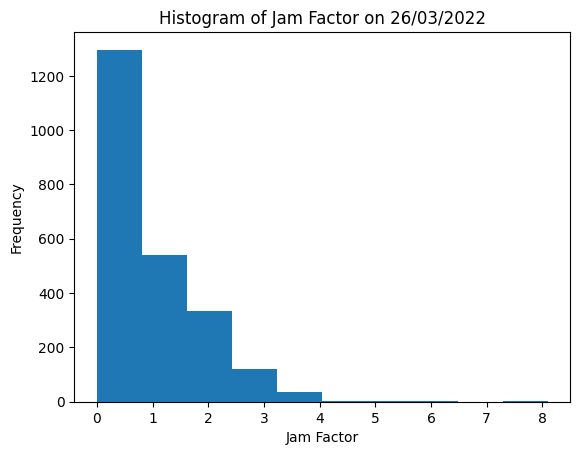

In [27]:
import matplotlib.pyplot as plt

# Create a histogram plot
plt.hist(gdf['JamFactor'], bins=10)

# Set the title and labels
plt.title('Histogram of Jam Factor on 26/03/2022')
plt.xlabel('Jam Factor')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [28]:
bin_edges = [-1, 1, 3, 4, 8, 11]

# use pd.cut to categorize the 'jamFactor' column
gdf['jamFactor_category'] = pd.cut(gdf['JamFactor'], bins=bin_edges)

gdf['group'] = gdf['jamFactor_category']
# print the count of observations in each category
print(gdf['group'].value_counts())

(-1, 1]    1435
(1, 3]      839
(3, 4]       52
(4, 8]        6
(8, 11]       1
Name: group, dtype: int64


<Axes: >

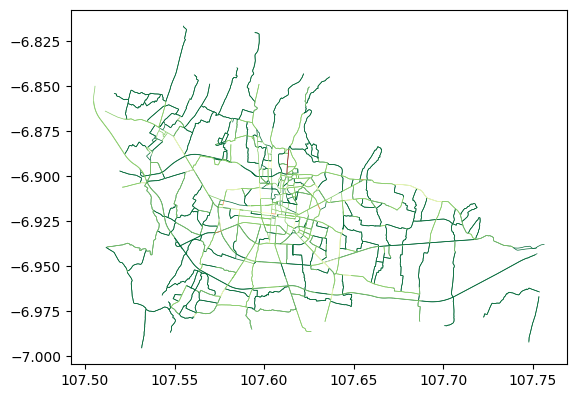

In [29]:
gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)

In [30]:
gdf['jamFactor_category']

0       (-1, 1]
1        (1, 3]
2       (-1, 1]
3       (-1, 1]
4       (-1, 1]
         ...   
2328    (-1, 1]
2329    (-1, 1]
2330    (-1, 1]
2331     (1, 3]
2332    (-1, 1]
Name: jamFactor_category, Length: 2333, dtype: category
Categories (5, interval[int64, right]): [(-1, 1] < (1, 3] < (3, 4] < (4, 8] < (8, 11]]

In [44]:
# #plot the lines on folium and save it as an HTML file:
# import folium

# def plot_lines_on_folium(gdf, fname, center_lat, center_lon, zoom_start):
#     # convert JamFactor_category column to string
#     gdf['jamFactor_category'] = gdf['jamFactor_category'].astype(str)
    
#     # create map centered at specified latitude and longitude
#     map_center = [center_lat, center_lon]
#     m = folium.Map(location=map_center, zoom_start=zoom_start,tiles='CartoDB dark_matter')

#     # iterate over rows and add each line to the map with corresponding color
#     for idx, row in gdf.iterrows():
#         color = None
#         if row['jamFactor_category'] == '(-1, 1]':
#             color = 'blue'
#         elif row['jamFactor_category'] == '(1, 3]':
#             color = 'green'
#         elif row['jamFactor_category'] == '(3, 4]':
#             color = 'yellow'
#         elif row['jamFactor_category'] == '(4, 8]':
#             color = 'orange'
#         elif row['jamFactor_category'] == '(8, 11]':
#             color = 'red'

#         if color:
#             folium.PolyLine(locations=row['geometry'].coords, color=color).add_to(m)

#     # save map as HTML file
#     m.save(f'{fname}')
    

In [84]:
def plot_lines_on_folium(gdf, fname, center_lat, center_lon, zoom_start):
    # convert JamFactor_category column to string
    gdf['jamFactor_category'] = gdf['jamFactor_category'].astype(str)
    
    # create map centered at specified latitude and longitude
    map_center = [center_lat, center_lon]
    m = folium.Map(location=map_center, zoom_start=zoom_start,tiles='CartoDB dark_matter')

    # Define the colors using RGB values
    color_dict = {
        '(-1, 1]': '#008000',
        '(1, 3]': '#7fff00',
        '(3, 4]': '#ffff00',
        '(4, 8]': '#ffa500',
        '(8, 11]': '#ff0000'
    }

    gdf['color'] = gdf['jamFactor_category'].map(color_dict)

    # iterate over rows and add each line to the map with corresponding color
    for idx, row in gdf.iterrows():
        color = None
        weight = 2
        opacity = 0.7
        if row['jamFactor_category'] in color_dict:
            color = color_dict[row['jamFactor_category']]
            
            # print(f"jamFactor_category: {row['jamFactor_category']}")
            # print(f"color: {color}")

        if color:
            folium.PolyLine(locations=row['geometry'].coords, color=color,weight=weight, opacity=opacity).add_to(m)

    # save map as HTML file
    m.save(f'{fname}')


In [85]:
import glob
import os

def process_here_maps_outputs(directory_path, output_dir):
    # Get a list of all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, '*.json'))

    for json_file in json_files:
        # Process each JSON file using the existing logic
        try: 
            df = dataframe(json_file)
        except:
            print("An exception occurred") 
        geometry = [LineString(list(zip(row['Longitudes'], row['Latitudes']))) for _, row in df.iterrows()]
        gdf = gpd.GeoDataFrame(df, geometry=geometry)
        gdf.crs = {'init':'epsg:4326'} 
        bin_edges = [-1, 1, 3, 4, 8, 11]
        gdf['jamFactor_category'] = pd.cut(gdf['JamFactor'], bins=bin_edges)
        gdf['group'] = gdf['jamFactor_category']
        gdf.sort_values("JamFactor").plot(column="group", cmap='RdYlGn_r', categorical=True, linewidth=.5)
        html_filename = os.path.splitext(os.path.basename(json_file))[0] + '.html'
        html_path = os.path.join(output_dir, html_filename)
        plot_lines_on_folium(gdf, html_path, -6.905977, 107.613144, 13)


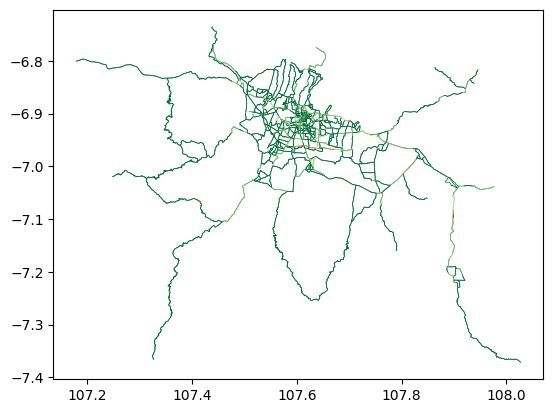

In [86]:
process_here_maps_outputs('E:\FASTRACK\SMT10\Bandung-Traffic\coba', 'E:\FASTRACK\SMT10\Bandung-Traffic\HTML')

In [88]:
import os
from selenium import webdriver
from time import sleep

def process_html_files(html_folder_path, screenshot_folder_path):
    # Get a list of all HTML files in the directory
    html_files = [f for f in os.listdir(html_folder_path) if f.endswith('.html')]

    for html_file in html_files:
        # Construct the file paths for the HTML and screenshot files
        html_file_path = os.path.join(html_folder_path, html_file)
        screenshot_file_path = os.path.join(screenshot_folder_path, os.path.splitext(html_file)[0] + ".png")

        # Open Chrome browser using Selenium web driver
        options = webdriver.ChromeOptions()
        options.add_argument('--ignore-certificate-errors')
        options.add_argument('--ignore-ssl-errors')
        driver = webdriver.Chrome(options=options)
        driver.get(os.path.abspath(html_file_path))

        # Wait for specified delay to ensure webpage has fully loaded
        sleep(5)

        # Maximize window and take screenshot
        driver.maximize_window()
        driver.save_screenshot(screenshot_file_path)

        # Close browser
        driver.quit()

        print(f"Screenshot saved as {screenshot_file_path}")


In [89]:
html_folder_path = 'E:\FASTRACK\SMT10\Bandung-Traffic\HTML'
screenshot_folder_path = 'E:\FASTRACK\SMT10\Bandung-Traffic\PNG'
process_html_files(html_folder_path, screenshot_folder_path)


Screenshot saved as E:\FASTRACK\SMT10\Bandung-Traffic\PNG\2023-03-26 22-01-30.png
